  # Hashing using Hierarchical Kmeans

## Importing the required packages.
>hierarchical_kmeans: Package inherited from github
The package defines a new class 'tree', and does hirearchical Kmeans clustering on a dataset for which an instance of the class 'tree' is be provided.
(https://github.com/github-pengge/hierarchical_kmeans)


In [62]:
%matplotlib inline
from hierarchical_kmeans import hierarchical_kmeans as hkmeans
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from hierarchical_kmeans import tree


>**Function Description**:The function generates the required tree structure to be provided as input for hkmeans object.<br>
**Function Name**:
generateClusterStructure()<br>
 **Arguments**:<br>
 1\.depth: The current depth of the tree being generated. Gets updated in each recursion call.<br>
 2\.desiredDepth: The total depth of the tree required(excluding the root)<br>
 3\.parent: The tree object which stores the current node for which 2 children are to be made<br>
 **Return**:
 Returns the complete binary tree structure of the required depth(to be determined by the hash value dimension)

In [63]:
def generateClusterStructure(depth,desiredDepth,parent):
    parentId = '' if parent.name == 'root' else parent.name
    if(depth>desiredDepth):
            return parent
    depth += 1
    for j in range(2):
        childId = parentId + str(j)
        child = tree(childId)
        child = generateClusterStructure(depth,desiredDepth,child)
        parent.add_child(child)
    return parent

>**Function Description**:The function generates the required 500,2-D data points from an ellipse. Each data point belongs to one of the eight translated and rotated ellipses. The major and minor axes of the ellipses are 5 and 2 respectively<br>
**Function Name**:
getDataFromEllipse()<br>
**Return**:
Returns the 2D-data vectors in Numpy array
  

In [64]:
def getDataFromEllipse():
    data = np.empty((2,1))
    a,b = 5,2
    n = 500
    pi = np.pi
    theta = [0,pi/4,pi/2,3*pi/4,pi,5*pi/4,3*pi/2,7*pi/4]
    center = np.array([5,0]).reshape(2,-1)
    centers = np.empty((2,1))
    for t in theta:
        rotation = np.array([[np.cos(t),np.sin(t)],[-np.sin(t),np.cos(t)]]).reshape(2,2)
        centers = np.append(centers,np.matmul(rotation,center).reshape(2,1),axis=1)
    centers = np.array(centers,dtype='int').reshape(2,-1)[:,1:]
    for index,t in enumerate(theta):
        for i in range(n):
            rotation = np.array([[np.cos(t),np.sin(t)],[-np.sin(t),np.cos(t)]]).reshape(2,2)
            phi = 2*np.pi* np.random.rand()
            rho = np.random.rand()
            pt = np.array([rho*np.cos(phi)*a/2,rho*np.sin(phi)*b/2]).reshape(2,-1)
            rotatedPt = np.matmul(rotation,pt)
            translatedPt = centers[:,index].reshape(2,-1)+rotatedPt.reshape(2,-1)
            data = np.append(data,translatedPt,axis = 1)
    return data[:,1:]

>**Function Description**:The function plots the division boundaries in each level of the hierarchical 2-means tree and the mean vectors at each level for 2-means clustering<br>
**Function Name**:
plotClustering()<br>
 **Arguments**:<br>
 1\.nodes: The list of nodes at a particular level whose children store the mean vectors of 2-means clustering <br>
 2\.customData: The data vectors which are clustered<br>

In [65]:
def plotClustering(nodes,customData):
    global level
    level += 1
    plt.figure()
    plt.title('Decision boundaries and Mean Vectors at level '+str(level))
    plt.scatter(customData[0,:],customData[1,:],color='c')
    children = np.array([])
    for node in nodes:
        children = np.append(children,node.children)
    means = np.array([[]]).reshape(2,-1)
    for child in children:
        mean = np.array(child.data).reshape(2,-1)
        means = np.append(means,mean,axis=1)
    x = np.linspace(-10,10,100)
    for i in range(0,means.shape[1],2):
        points = means[:,i:(i+2)]
        point = np.mean(points,axis =1)
        m = -(np.diff(points,axis=1)[0]/np.diff(points,axis=1)[1])
        y = m*((x-point[0]))+point[1]
        axes = plt.gca()
        color=next(axes._get_lines.prop_cycler)['color']
        axes.set_xlim([-15,15])
        axes.set_ylim([-15,15])
        plt.plot(x,y,color=color)
        plt.scatter(points[0,:],points[1,:],color=color)
    if(children[0].is_leaf_node()):
        return
    else:
        plotClustering(children,customData)

>The following python script computes hierarchical clustering on the 2D-data generated. The data along with the tree structure generated(here 3 level binary tree) are passed as input argument to the hkmeans object to hierarchical cluster the data. The plots show the data in 2D space and how the mean vectors(colored dots) and decision boundary change in each levels of hierarchy. The decision boundaries at level 2 coincide exaclty(Therfore the 2 seperate boundaries aren't exaclty visible). There are 4 decision boundaries at level 3.

Doing hierarchical kmeans...
Done! Actual total number of clusters is 8.


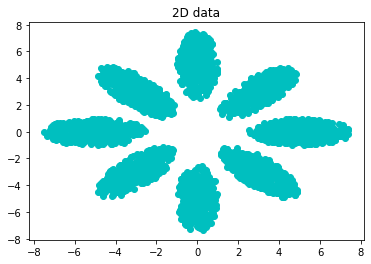

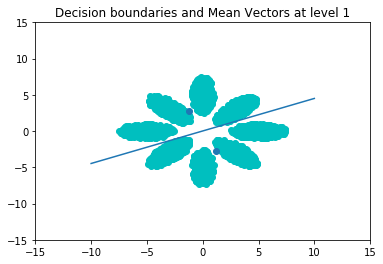

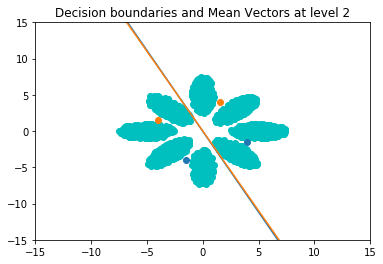

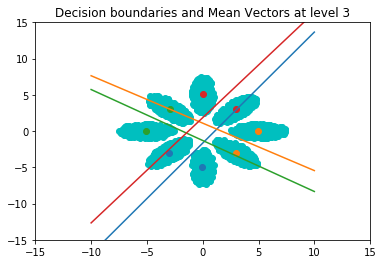

In [66]:
customData = getDataFromEllipse()
plt.title('2D data')
plt.scatter(customData[0,:],customData[1,:],color='c')
testClusterStructure = tree('root')
generateClusterStructure(1,3,testClusterStructure)
hk1 = hkmeans(testClusterStructure)
hk1.cluster(customData.T, only_store_id=False, iteration=1)
testTreeRoot = hk1.root
level = 0
plotClustering([testTreeRoot],customData)

>**Function Description**:The function generates the hash map for the training dataset.<br>
**Function Name**:
saveHashMap()<br>
 **Arguments**:<br>
 1\.hk: hkmeans object which contains the hierarchically clustered data(of type tree).The hash values stored as name attribute a particular node in the tree<br>
 2\.hashMap: Stores the generated hash map<br>


In [67]:
def saveHashMap(hk,hashMap):
    leafNodes = []
    hk.root.gather_leaves(leafNodes)
    leafNodes = np.array(leafNodes)
    for node in leafNodes:
        hashMap[node.name] = node.get_additional_data()

In [68]:
maxDepth = 9
hashMap = {}     
dataset = np.genfromtxt('mnist_train.csv',delimiter=',')
trainData,testData = train_test_split(dataset,test_size=0.1)
clusterStructure = tree('root')
generateClusterStructure(1,maxDepth,clusterStructure)
hk = hkmeans(clusterStructure)
hk.cluster(trainData, only_store_id=False, iteration=1)
saveHashMap(hk,hashMap)
testLeafNode = hk.find_cluster(testData[0], max_depth=-1)
meanNeighbor = testLeafNode.get_data()


Doing hierarchical kmeans...
Done! Actual total number of clusters is 512.


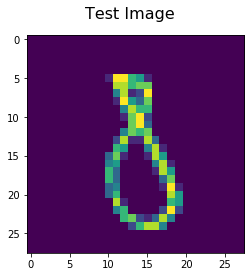

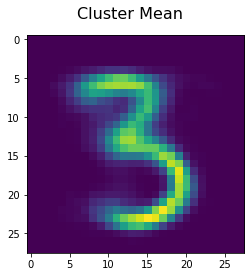

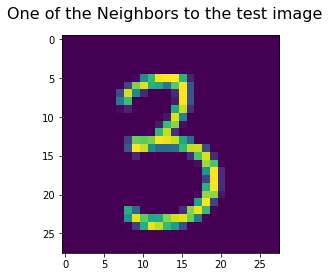

In [69]:
neighbors = testLeafNode.get_additional_data()
fig = plt.figure()
fig.suptitle('Test Image',fontsize=16)
plt.imshow(testData[0].reshape(28,28))
fig = plt.figure()
fig.suptitle('Cluster Mean', fontsize=16)
plt.imshow(meanNeighbor.reshape(28,28))
fig = plt.figure()
fig.suptitle('One of the Neighbors to the test image', fontsize=16)
fig = plt.imshow(neighbors[0].reshape(28,28))

Hash values can be generated for each test image and can be lookedup in hashMap to resolve immediate neighbors.

Hash value generated for the image: 111011111
The neighboring images....


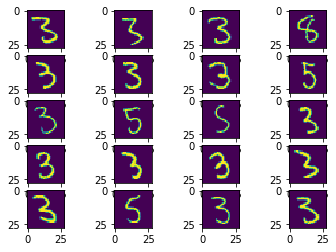

In [70]:
testHashValue = testLeafNode.name
print("Hash value generated for the image:",testHashValue)
print("The neighboring images....")
neighbors = hashMap[testHashValue]
count = 1
for i in range(5):
    for j in range(4):
        plt.subplot2grid((5,4), (i,j))
        plt.imshow(neighbors[count].reshape(28,28))
        count += 1


Similarly farthest images with respect to test image can be determined using hamming distances of the hash codes generated.